In [ ]:
# # IMPORT ENERGY MEASUREMENT TIME-SERIES DATA

# import requests
# import matplotlib.dates as pltd

# # SOURCE https://www.eia.gov/opendata (hourly eletrical monitoring)
# YOUR_API_KEY_HERE = "00f59ba568f99890e7d520e57da5e80a"
# url = 'http://api.eia.gov/series/?api_key=%s&series_id=EBA.CAL-ALL.NG.H' % YOUR_API_KEY_HERE

# # Convert data into suitable format for tensor flow and LSTM
# response = requests.post(url)
# a=response.json()['series'][0]['data']

# #Convert time into date time objects
# listOfDatetimes=[]
# for i in np.arange(np.shape(a)[0]):
#     listOfDatetimes.append(dateutil.parser.parse(a[i][0]))

# dates = pltd.date2num(listOfDatetimes)

# # Extract data into list
# raw_values=[]
# for i in np.arange(np.shape(a)[0]):
#     raw_values.append(a[i][1])
    
# del a, listOfDatetimes, response, url, i, YOUR_API_KEY_HERE

# # Reduce data size
# max_n = 1000
# raw_values = raw_values[0:max_n]

# # Plot data
# pltp.plot_date(dates[0:max_n], raw_values)
# pltp.title('Raw data')
# pltp.xticks(rotation=45)
# pltp.show()

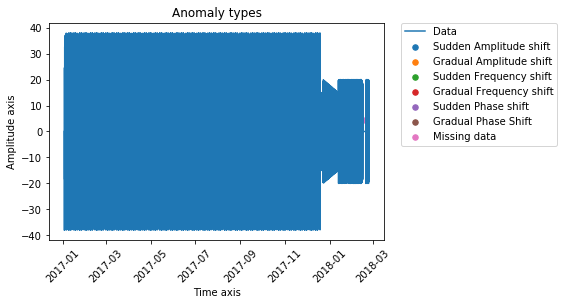

In [3]:
"""
Interpretation of "https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/"
"""

# IMPORT SIMULATED DATA
import matplotlib.pyplot as pltp
import numpy as np
import dateutil.parser
import pandas as pd
from sklearn.metrics import mean_squared_error
from SimAnomalyDataset import get_data
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

data, anomaly_loc = get_data()
raw_values = data

# Input data cooking

def difference(dataset, interval=1):
    """
    Transform the Time series to stationary (i.e. remove trends) with difference series
    """
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def timeseries_to_supervised(data, lag=1):
    """
    Transform time series to supervised learning data (shift  values -1) input into DATAFRAME
    Frame a sequence as a supervised learning problem
    """
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


def scale(train, test):
    """
    scale train and test data to [-1, 1]
    """
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# transform data to be stationary
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
del diff_values
supervised_values = supervised.values

# split data into train and test-sets
tr_size = 8000
train, test = supervised_values[0:tr_size], supervised_values[-tr_size:]
#del supervised_values

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

def inverse_difference(history, yhat, interval=1):
    """
    invert differenced value (obtain original scale prior to differencing)
    """
    return yhat + history[-interval]


def invert_scale(scaler, X, value):
    """
    inverse scaling for a forecasted value
    """
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# fit the model
batch_sz = 1
num_epoch = 100
neurons = 3
lstm_model = fit_lstm(train_scaled, batch_sz, num_epoch, neurons)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=batch_sz)

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


In [7]:
# walk-forward validation on the test data
predictions = []
for i in range(len(raw_values)-2):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


IndexError: index 10000 is out of bounds for axis 0 with size 10000

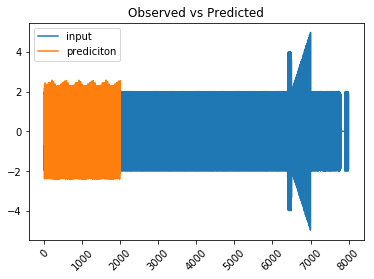

In [3]:
#line plot of observed vs predicted
pltp.figure(1)
plot_shape = np.size(predictions)
pltp.plot( raw_values[-tr_size:],label='input')
pltp.plot( predictions, label='prediciton')
pltp.title('Observed vs Predicted')
pltp.legend()
pltp.xticks(rotation=45)
pltp.show()

pltp.figure(2)
#pltp.plot_date(dates[1000:1199], S)
pltp.plot_date(dates[1000:1199],1-L)
pltp.title('Anomaly Likelihood')
pltp.xticks(rotation=45)
pltp.ylim(0,1)
pltp.show()

In [ ]:
# Model Parameters
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly

# Model input and output
x = tf.placeholder(tf.float32,[data_labels]) #input
h = tf.Variable(,dtype=tf.float32) #output
c = tf.Variable(,dtype=tf.float32) #input

# Model equations
sigma = 1/(1+np.exp(-x)) # range 0 to 1
tanh = (2/(1+np.exp(-x))) - 1 # range -1 to 1

lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

# Initial state of the LSTM memory.
hidden_state = tf.zeros([batch_size, lstm.state_size])
current_state = tf.zeros([batch_size, lstm.state_size])
state = hidden_state, current_state
probabilities = []
loss = 0.0
for current in x:
    # The value of state is updated after processing each batch of words.
    output, state = lstm(current, state)

    # The LSTM output can be used to make next word predictions
    logits = tf.matmul(output, softmax_w) + softmax_b
    probabilities.append(tf.nn.softmax(logits))
    loss += loss_function(probabilities, target_words)

    
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b  # + provides a shortcut for tf.add(a, b)

print(sess.run(adder_node, {a: 3, b: 4.5}))
print(sess.run(adder_node, {a: [1, 3], b: [2, 4]}))

W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
f = W * x + b

init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(linear_model, {x: [1, 2, 3, 4]}))

y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

tf.train.